# Import required packages

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

from keras import Sequential
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical

from tensorflow.keras.models import Model


from keras.preprocessing.image import load_img

<ipython-input-2-4b66f1066aab>:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import google drive data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create a model save path

In [4]:
model_path = '/content/drive/My Drive/notebook_data_and_output/model2/DogClassification.h5'

# Check GPU availibility

In [5]:
print("GPU", "available (Yes)" if tf.config.list_physical_devices("GPU") else "not available :(")
tf.config.list_physical_devices("GPU")

GPU available (Yes)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Read the labels from CSV file on Kagel

In [6]:
print(os.listdir('/content/drive/My Drive/notebook_data_and_output/dataset2/'))
labels = pd.read_csv('/content/drive/My Drive/notebook_data_and_output/dataset2/labels.csv')
labels.head()

['train', 'test', 'labels.xlsx', 'labels.csv', 'sample_submission.xlsx', 'sample_submission.csv']


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# Describe the labels

In [7]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,fff43b07992508bc822f33d8ffd902ae,scottish_deerhound
freq,1,126


# Function to show the bar length of the data

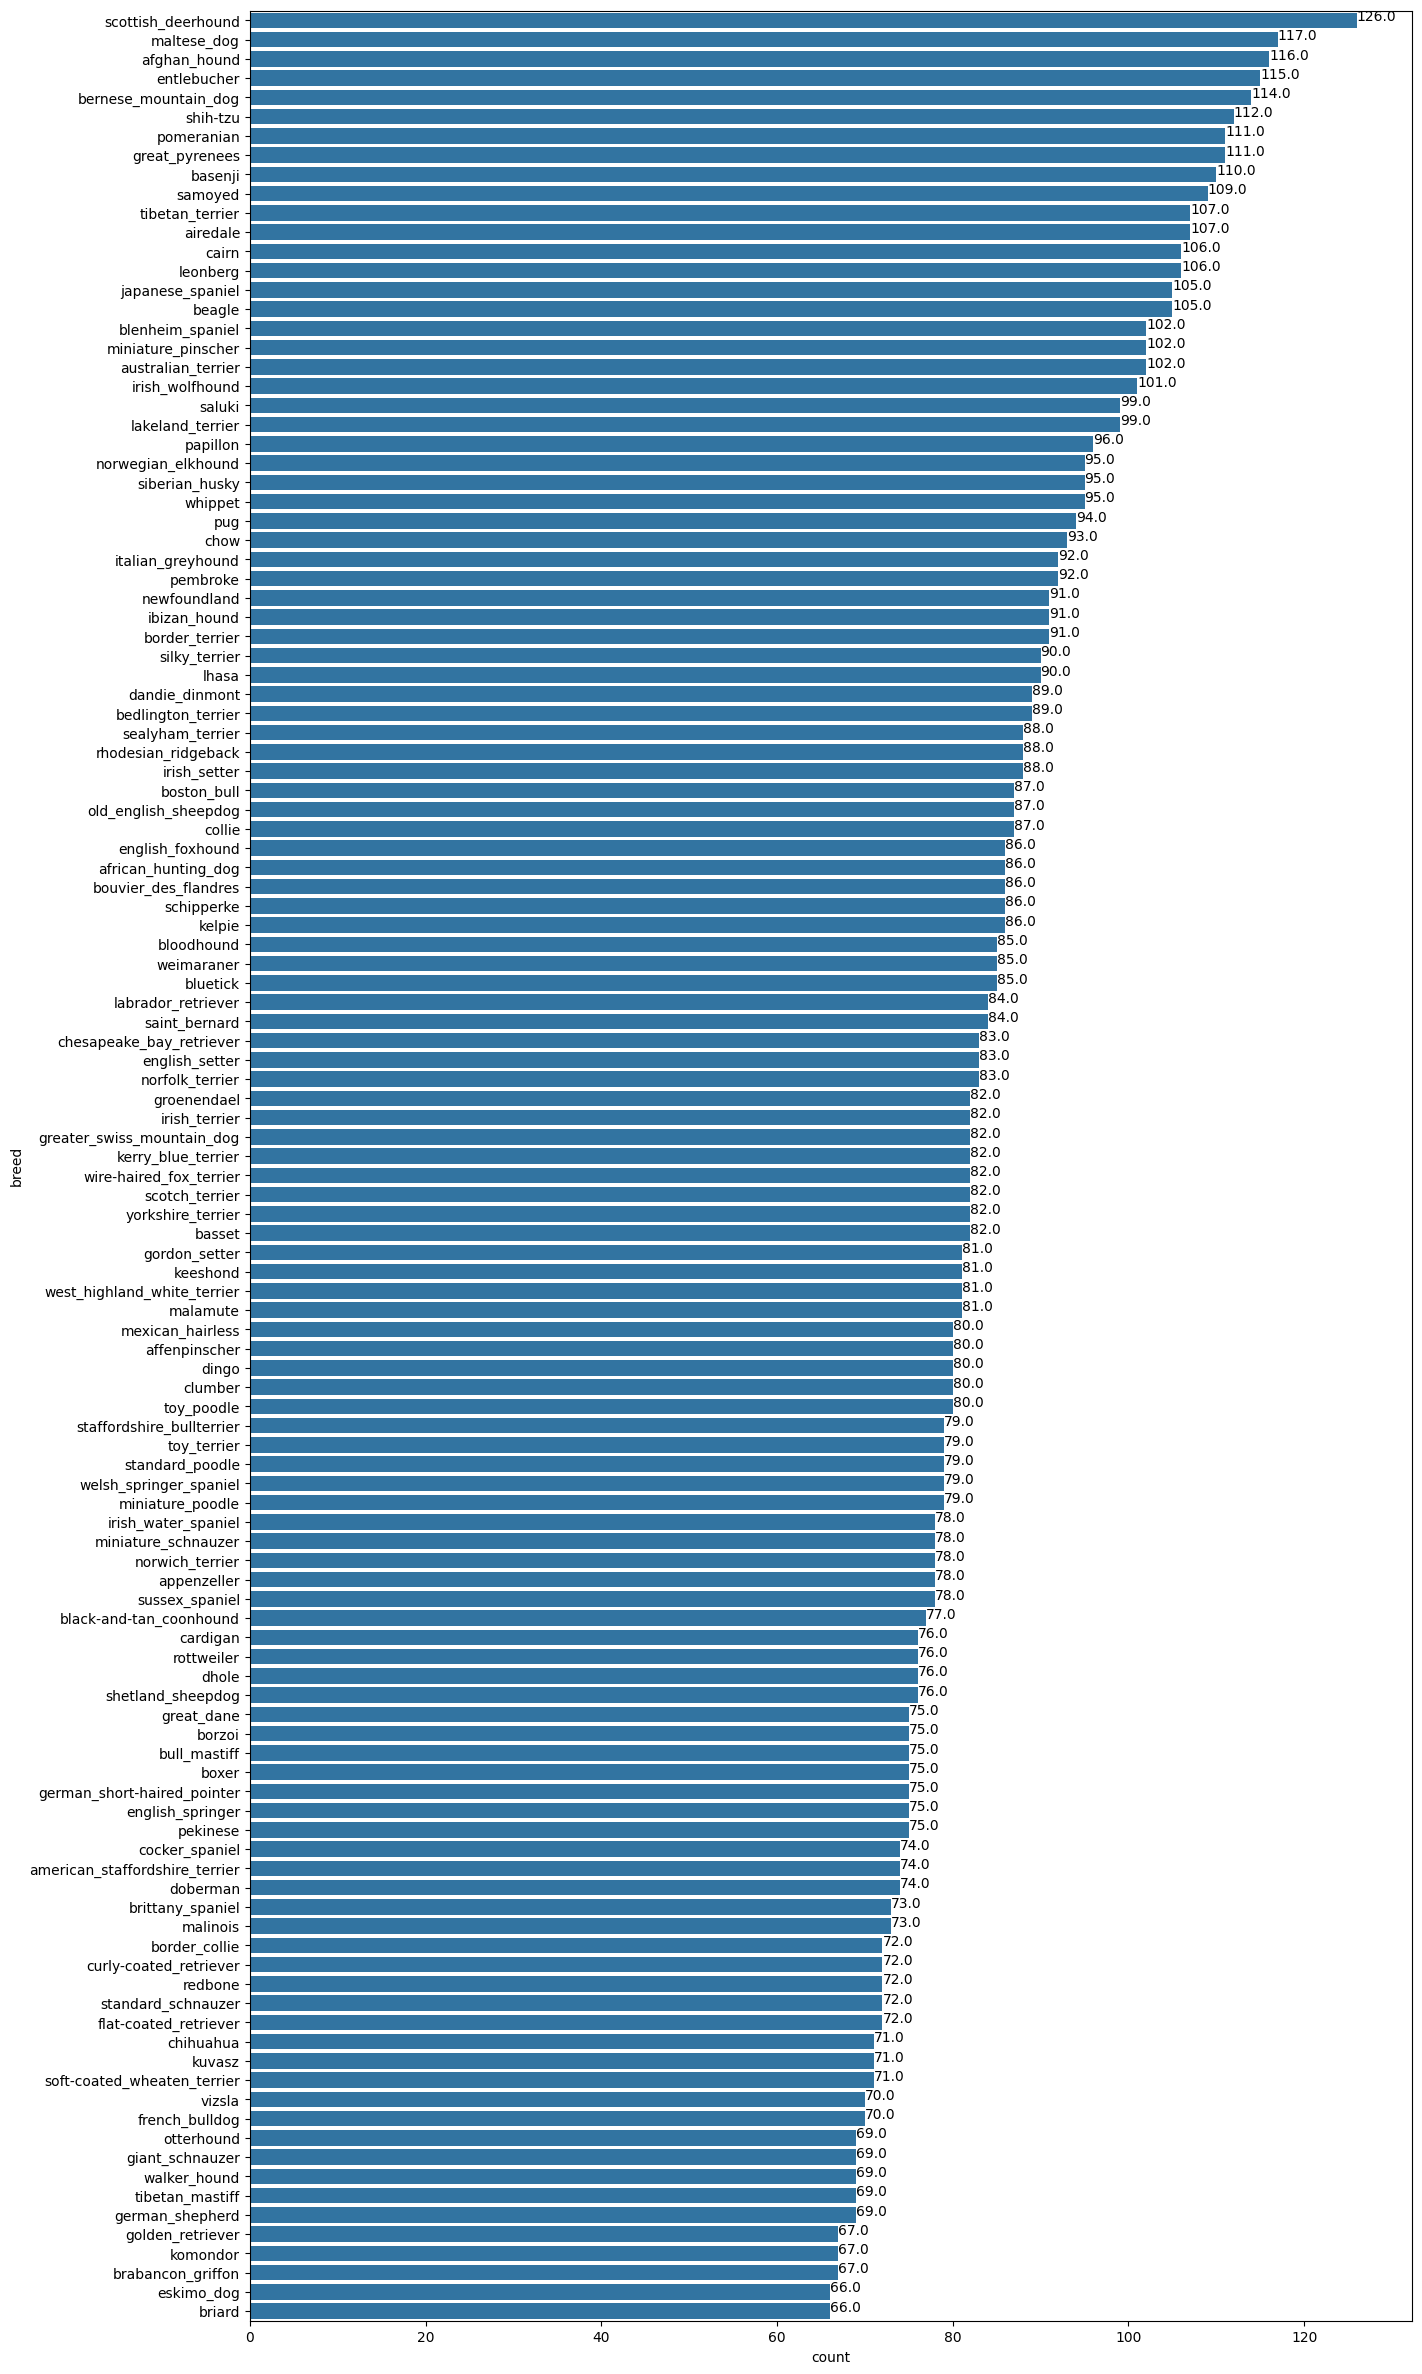

In [8]:
def barw(ax):

    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels['breed'],order=labels['breed'].value_counts().index)
barw(ax0)
plt.show()

# Test if the files match

In [9]:
import os
print('Number of file matches number of actual images' if len(os.listdir('/content/drive/My Drive/notebook_data_and_output/dataset2/train/')) == len(labels['id']) else 'Number of file does not match number of actual images')

Number of file matches number of actual images


# Create a list of alphabetically sorted labels

In [10]:
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))

Total unique breed 120


# Map each label string to a integer

In [11]:
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

# Loading and processing dog breed images to numpy arrays

In [12]:
input_shape = (331,331,3)


def images_to_array(directory, label_dataframe, target_size = input_shape):

    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)

    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img

        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]

    y = to_categorical(y)

    return images,y

# Measuring runtime for Loading dog breed images

In [13]:
import time
t = time.time()

X,y = images_to_array('/content/drive/My Drive/notebook_data_and_output/dataset2/train/', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds: 379.0957887172699


# Create a figure to show different images loading

In [14]:
# np.where(y[5]==1)[0][0]

n=25

plt.figure(figsize=(20,20))

for i in range(n):
#     print(i)
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32'))

Output hidden; open in https://colab.research.google.com to view.

# Learning parameters and early stop trigger configuration

In [15]:
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Hyperparameters

In [16]:
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

# Function to extract features from the dataset by a given pretrained model

In [17]:
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)

    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

# Extract features using InceptionV3

In [18]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

320/320 [==============================] - 27s 63ms/step
Feature maps shape:  (10222, 2048)


# Extract features using Xception

In [19]:
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

320/320 [==============================] - 46s 136ms/step
Feature maps shape:  (10222, 2048)


# Extract features using InceptionResNetV2

In [20]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

320/320 [==============================] - 62s 180ms/step
Feature maps shape:  (10222, 1536)


# Extract features using NASNetLarge

In [21]:
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

320/320 [==============================] - 159s 481ms/step
Feature maps shape:  (10222, 4032)


# Free up some memory

In [22]:
del X
gc.collect()

165762

# Creating final featuremap by combining all extracted features

In [23]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1) #axis=-1 to concatinate horizontally

print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 9664)


#Prepare Deep net and draw loss diagram

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 9664)              0         
                                                                 
 dense (Dense)               (None, 120)               1159800   
                                                                 
Total params: 1159800 (4.42 MB)
Trainable params: 1159800 (4.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
57/64 [=========================>....] - ETA: 0s - loss: 1.0970 - accuracy: 0.7837


Epoch 1: val_loss improved from inf to 0.18838, saving model to /content/drive/My Drive/notebook_data_and_output/model2/DogClassification.h5
64/64 [==============================] - 5s 48ms/step - loss: 1.0042 - accuracy: 0.7994 - val_loss: 0.1884 - val_accuracy: 0.9384 - lr: 0.0010
Epoch 2/50
59/64 [==========================>...] - ETA: 0s - loss: 0.1762 - accuracy: 0.9444


Epoch 2: val_loss improved from 0.18838 to 0.18044, saving model to /content/drive/My Drive/notebook_data_and_output/model2/DogClassification.h5
64/64 [==============================] - 0s 5ms/step - loss: 0.1757 - accuracy: 0.9446 - val_loss: 0.1804 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 3/50
58/64 [==========================>...] - ETA: 0s - loss: 0.1365 - accuracy: 0.9558


Epoch 3: val_loss improved from 0.18044 to 0.17417, saving model to /content/drive/My Drive/notebook_data_and_output/model2/DogClassification.h5
64/64 [==============================] - 0s 6ms/step - loss: 0.1347 - accuracy: 0.9559 - val_loss: 0.1742 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 4/50
57/64 [=========================>....] - ETA: 0s - loss: 0.1082 - accuracy: 0.9650


Epoch 4: val_loss did not improve from 0.17417
64/64 [==============================] - 0s 5ms/step - loss: 0.1109 - accuracy: 0.9645 - val_loss: 0.1816 - val_accuracy: 0.9399 - lr: 0.0010
Epoch 5/50
54/64 [========================>.....] - ETA: 0s - loss: 0.0957 - accuracy: 0.9690


Epoch 5: val_loss did not improve from 0.17417
64/64 [==============================] - 0s 5ms/step - loss: 0.0972 - accuracy: 0.9686 - val_loss: 0.1854 - val_accuracy: 0.9399 - lr: 0.0010
Epoch 6/50
56/64 [=========================>....] - ETA: 0s - loss: 0.0793 - accuracy: 0.9731


Epoch 6: val_loss did not improve from 0.17417
64/64 [==============================] - 0s 5ms/step - loss: 0.0770 - accuracy: 0.9743 - val_loss: 0.1814 - val_accuracy: 0.9418 - lr: 0.0010
Epoch 7/50
57/64 [=========================>....] - ETA: 0s - loss: 0.0696 - accuracy: 0.9774


Epoch 7: val_loss did not improve from 0.17417
64/64 [==============================] - 0s 5ms/step - loss: 0.0700 - accuracy: 0.9777 - val_loss: 0.1921 - val_accuracy: 0.9369 - lr: 0.0010
Epoch 8/50
54/64 [========================>.....] - ETA: 0s - loss: 0.0608 - accuracy: 0.9789


Epoch 8: val_loss did not improve from 0.17417
64/64 [==============================] - 0s 5ms/step - loss: 0.0624 - accuracy: 0.9782 - val_loss: 0.1938 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 9/50
57/64 [=========================>....] - ETA: 0s - loss: 0.0524 - accuracy: 0.9840


Epoch 9: val_loss did not improve from 0.17417
64/64 [==============================] - 0s 5ms/step - loss: 0.0515 - accuracy: 0.9840 - val_loss: 0.1960 - val_accuracy: 0.9345 - lr: 0.0010
Epoch 10/50
56/64 [=========================>....] - ETA: 0s - loss: 0.0447 - accuracy: 0.9865


Epoch 10: val_loss did not improve from 0.17417
64/64 [==============================] - 0s 5ms/step - loss: 0.0442 - accuracy: 0.9869 - val_loss: 0.1915 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 11/50
54/64 [========================>.....] - ETA: 0s - loss: 0.0392 - accuracy: 0.9893


Epoch 11: val_loss did not improve from 0.17417
64/64 [==============================] - 0s 5ms/step - loss: 0.0416 - accuracy: 0.9878 - val_loss: 0.1939 - val_accuracy: 0.9438 - lr: 0.0010
Epoch 12/50
54/64 [========================>.....] - ETA: 0s - loss: 0.0389 - accuracy: 0.9878


Epoch 12: val_loss did not improve from 0.17417
64/64 [==============================] - 0s 5ms/step - loss: 0.0377 - accuracy: 0.9879 - val_loss: 0.2007 - val_accuracy: 0.9384 - lr: 0.0010
Epoch 13/50
57/64 [=========================>....] - ETA: 0s - loss: 0.0354 - accuracy: 0.9905


Epoch 13: val_loss did not improve from 0.17417
64/64 [==============================] - 0s 5ms/step - loss: 0.0347 - accuracy: 0.9910 - val_loss: 0.2059 - val_accuracy: 0.9408 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


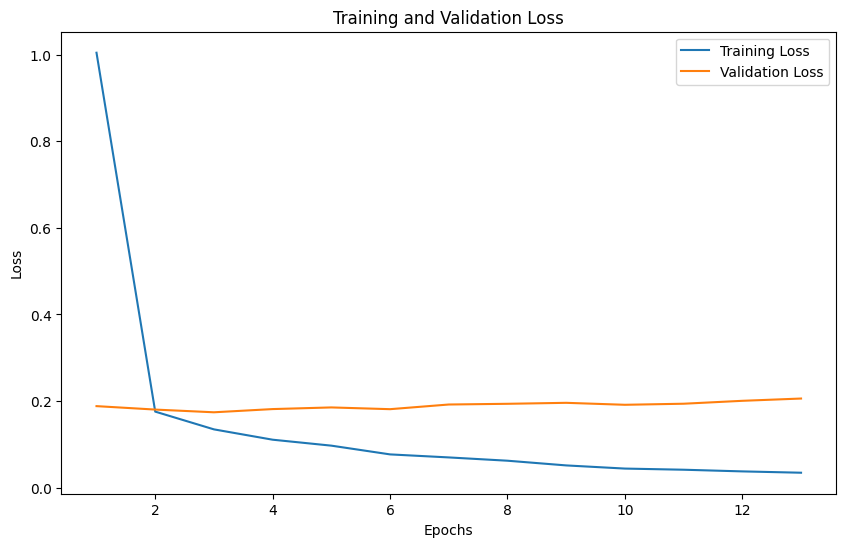

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming final_features and y are defined properly
# Define your model
model = Sequential()
model.add(Dropout(0.7, input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model with the optimizer
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary to check the architecture
model.summary()

# Train the model
history = model.fit(final_features, y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[lrr, EarlyStop, model_checkpoint],
                    verbose=1)
# Save the model
model.save(model_path)
# Plotting the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#Deleting to free up ram memory

In [25]:
del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

5096

#Function to read images from test directory

In [26]:
def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)


    for ix,img_dir in enumerate(tqdm(test_filenames)):
#         img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = img_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('/content/drive/My Drive/notebook_data_and_output/dataset2/test/', img_size)

  0%|          | 0/10357 [00:00<?, ?it/s]

Ouptut Data Size:  (10357, 331, 331, 3)


#Extract test data features

In [27]:
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)

    print('Final feature maps shape', final_features.shape)

    #deleting to free up ram memory
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()


    return final_features

test_features = extact_features(test_data)

324/324 [==============================] - 23s 66ms/step
Feature maps shape:  (10357, 2048)
324/324 [==============================] - 46s 139ms/step
Feature maps shape:  (10357, 2048)
324/324 [==============================] - 161s 481ms/step
Feature maps shape:  (10357, 4032)
324/324 [==============================] - 62s 181ms/step
Feature maps shape:  (10357, 1536)
Final feature maps shape (10357, 9664)


#Free up some space.

In [28]:
del test_data
gc.collect()

0

#Predict test labels given test data features.

In [29]:
pred = model.predict(test_features)

324/324 [==============================] - 1s 2ms/step


# First prediction

In [30]:
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

[1.37533832e-04 2.22683404e-04 5.44819413e-05 2.48487740e-05
 3.12748947e-03 1.51350992e-04 4.74774606e-05 6.31497896e-05
 5.93095092e-06 4.15544200e-05 1.88900922e-05 2.88674596e-06
 9.36938683e-04 6.00306412e-05 4.42023193e-05 1.42170393e-04
 1.34549293e-04 1.86355428e-05 3.23647473e-05 3.34809811e-05
 1.40466887e-04 2.13357224e-03 1.72542103e-04 2.80088716e-05
 2.72431521e-06 1.16408127e-03 1.62249053e-05 2.04098742e-05
 2.11161401e-04 6.88728178e-05 1.76066624e-05 1.95983157e-05
 2.05881224e-05 1.13780799e-04 2.99726562e-05 9.20717321e-06
 6.68979119e-05 9.25705608e-05 2.16597039e-03 2.71079352e-05
 9.49048990e-05 1.04057881e-05 7.38541257e-06 6.21125437e-05
 5.37007698e-04 8.24972012e-05 1.57617455e-04 4.45982441e-04
 6.06722955e-04 4.03653648e-05 2.65846593e-05 9.11002815e-01
 3.13813434e-05 1.91822342e-04 1.15328639e-05 9.19758986e-06
 1.77326816e-04 2.94631518e-05 5.84362351e-06 6.38202822e-04
 4.32759698e-04 2.76190331e-05 3.46310917e-05 1.85885845e-04
 2.67531796e-05 2.632215

# Create pandas DataFrame with empty columns

In [31]:
preds_df = pd.DataFrame(columns=["id"] + list(classes))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


# Append test image ID's to predictions DataFrame

In [32]:
test_path = "/content/drive/My Drive/notebook_data_and_output/dataset2/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e726ac27864ecbde1f5822c4d6e26c17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e732916519751eaa0cb2ba0cc1217ab9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e7dc8cc599049ea9fa2a172c88646c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e7e9dd51302fe08c1c89a550e183cf07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e783e22d4f370b6cc0b1f44b4d6584a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prediction results to the respective class labels

In [33]:
preds_df.loc[:,list(classes)]= pred

preds_df.to_csv('sample_submission.csv',index=None)
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e726ac27864ecbde1f5822c4d6e26c17,0.000138,0.000223,0.000054,0.000025,0.003127,0.000151,0.000047,0.000063,0.000006,...,0.000025,0.00005,0.000981,0.000062,0.001211,0.000028,0.000009,0.020337,0.000035,0.000048
1,e732916519751eaa0cb2ba0cc1217ab9,0.000003,0.00001,0.000001,0.000001,0.000001,0.000001,0.000002,0.000001,0.000002,...,0.000012,0.000002,0.000002,0.000001,0.000001,0.000011,0.000001,0.000001,0.000002,0.000003
2,e7dc8cc599049ea9fa2a172c88646c57,0.000003,0.000002,0.000001,0.000001,0.000001,0.000003,0.000004,0.000001,0.0,...,0.000005,0.000045,0.000002,0.000001,0.000001,0.000002,0.000001,0.000002,0.000002,0.000003
3,e7e9dd51302fe08c1c89a550e183cf07,0.000128,0.000042,0.000018,0.00004,0.000017,0.000022,0.046479,0.000043,0.000006,...,0.000148,0.002096,0.000112,0.000035,0.000038,0.000012,0.000014,0.000033,0.000116,0.921742
4,e783e22d4f370b6cc0b1f44b4d6584a8,0.000009,0.000004,0.000002,0.0,0.006198,0.000005,0.000007,0.000004,0.0,...,0.000002,0.000011,0.000008,0.000002,0.000001,0.000002,0.000003,0.000071,0.000005,0.000001
